In [255]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from joblib import dump

import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
# --------------------- #
# Step 1: Load the data #
# --------------------- #
df = pd.read_excel("MasterDataset_ML.xlsx")

In [257]:
# --------------------------------------------------------------------- #
# Step 1.1: Remove referees that have a count less than a certain value #
# --------------------------------------------------------------------- #
counts = df['Referee'].value_counts()
rare_refs = counts[counts < 70].index
df = df[~df['Referee'].isin(rare_refs)]

# ----------------------------------- #
# Step 2: Define targets and features #
# ----------------------------------- #
TargetReferee = True

Target = "Referee" if TargetReferee == True else "WIN"
Feature = 'Referee' if Target == 'WIN' else 'WIN'

# --------------------------------------------------------------- #
# Step 2.1: If Target = "WIN", then remove the goal score columns #
# --------------------------------------------------------------- #
if (Target=="WIN"):
    df = df.drop('H_Score', axis=1)
    df = df.drop('A_Score', axis=1)

# df = df.drop(['MatchId', "Season Start Year"], axis=1) # Might not need this but keep for now..
df = df.drop(['MatchId'], axis=1) # Might not need this but keep for now..

y = df[Target] 
x = df.drop(Target, axis=1)

In [258]:
# ------------------------------- # 
# Step 3: Label encode the target # 
# ------------------------------- # 
le = LabelEncoder() 
y_encoded = le.fit_transform(y)

In [259]:
# ---------------------------------------------- # 
# Step 4: One hot encode key categorical columns # 
# ---------------------------------------------- # 
# categorial_columns = ["Home", "Away", "NearestMajorCity", "HomeCity", Feature] # Older
categorial_columns = ["Home", "Away", "Stadium City", "Referee - UK Region of Birth", "Season Start Year", Feature] # Old 2
# categorial_columns = ["Home", "Away", "Stadium City", "Referee - UK Region of Birth", Feature] # Old 2
x_encoded = pd.get_dummies(x, columns=categorial_columns, drop_first=True)

In [260]:
# ------------------------- #
# Step 5: Imputer & Scaling #
# ------------------------- #
Simple = True

# -------------- #
# SIMPLE IMPUTER #
# -------------- #
if (Simple):
    # IMPUTE
    imputer = SimpleImputer(strategy='mean')
    x_imputed = pd.DataFrame(imputer.fit_transform(x_encoded), columns=x_encoded.columns)

    # SCALE
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_imputed)
    
# ----------- #
# KNN IMPUTER #
# ----------- #
else :
    # SCALE
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_encoded)
    x_scaled_df = pd.DataFrame(x_scaled, columns=x_encoded.columns)

    # IMPUTE
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    x_imputed = pd.DataFrame(imputer.fit_transform(x_scaled_df), columns=x_scaled_df.columns)

# The x value that goes into train_test_split
TTS_xValue = x_scaled if Simple == True else x_imputed

In [261]:
# ------------------------ #
# Step 6: Split train/test #
# ------------------------ #
x_train, x_test, y_train, y_test = train_test_split(
    TTS_xValue, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [262]:
# --------------------------- #
# Step 7: Train Random Forest #
# --------------------------- #
if Target == "Referee":
    # rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf = RandomForestClassifier(class_weight="balanced", max_depth= 20, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 200, random_state=42)

# --------------------------------------------------- #
# If the target was which side won [home, away, draw] #
# --------------------------------------------------- #
else:
    weights = {
        0: 1.1,
        1: 1.4,
        2: 0.7,
    }
    rf = RandomForestClassifier(class_weight=weights, max_depth= 30, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 300, random_state=42)

rf.fit(x_train, y_train)

# *************************** #
# Related to Streamlit output #
# *************************** #
filepath = "Referee_Model" if Target == "Referee" else "Result_Model"
model_filename = "referee_model.pkl" if Target == "Referee" else "result_model.pkl"

dump(rf, f"{filepath}/{model_filename}")
dump(le, f"{filepath}/target_labelencoder.pkl")
dump(imputer, f"{filepath}/imputer.pkl")
dump(scaler, f"{filepath}/scaler.pkl")
dump(list(x_encoded.columns), f"{filepath}/model_columns.pkl")

y_pred = rf.predict(x_test)

In [263]:
# ----------------------------- #
# Step 8 - Evaluate Performance #
# ----------------------------- #
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy:  0.20199275362318841
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.03      0.05        72
           1       0.46      0.30      0.37        43
           2       0.11      0.21      0.14        19
           3       0.08      0.05      0.06        41
           4       0.47      0.68      0.56        22
           5       0.00      0.00      0.00        74
           6       0.10      0.19      0.13        32
           7       0.44      0.78      0.56        18
           8       0.11      0.33      0.16        15
           9       0.09      0.26      0.13        27
          10       0.70      0.43      0.53        54
          11       0.59      0.52      0.55        25
          12       0.06      0.03      0.04        38
          13       0.13      0.28      0.18        18
          14       0.08      0.21      0.12        33
          15       0.10      0.13      0.12        23
          16       0.11    

In [264]:
# -------------------------------------------- #
# Step 9 - Feature Importance (Detection Bias) #
# -------------------------------------------- #
importances = rf.feature_importances_
features = x_encoded.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 15 Most Influential Features:")
print(importance_df.head(15))

# -------------------------------- #
# Confederation Feature Importance #
# -------------------------------- #
federation_importance = importance_df[importance_df['Feature'].str.contains("AFC|CAF|UEFA|CONMEBOL|CONCACAF|OFC")]
print("\nFederation Feature Importance")
print(federation_importance)

grouped_importance = importance_df.groupby(
    importance_df['Feature'].apply(
        lambda x: 'Federation' if any(f in x for f in ["AFC", "CAF", "UEFA", "CONMEBOL", "CONCACAF", "OFC"])
        else 'RefereeBirthCity' if 'Referee - UK Region of Birth' in x
        else 'MatchStats'
    )
)['Importance'].sum()
print("\nGrouped Feature Importances:")
print(grouped_importance)


Top 15 Most Influential Features:
                                Feature  Importance
132  Referee - UK Region of Birth_North    0.108177
133  Referee - UK Region of Birth_South    0.095271
6                     A_Ball_Possession    0.043004
5                     H_Ball_Possession    0.042432
1                    Stadium Attendance    0.039851
8                          A_Free_Kicks    0.036508
7                          H_Free_Kicks    0.035915
12                              A_Fouls    0.035819
0                      Stadium Capacity    0.035405
11                              H_Fouls    0.034172
2       Proportion of Foreigners Carded    0.033706
9                        H_Corner_Kicks    0.033443
10                       A_Corner_Kicks    0.030109
14                       A_Yellow_Cards    0.026905
13                       H_Yellow_Cards    0.026517

Federation Feature Importance
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Grouped Feature Importances:
Feature
MatchSt

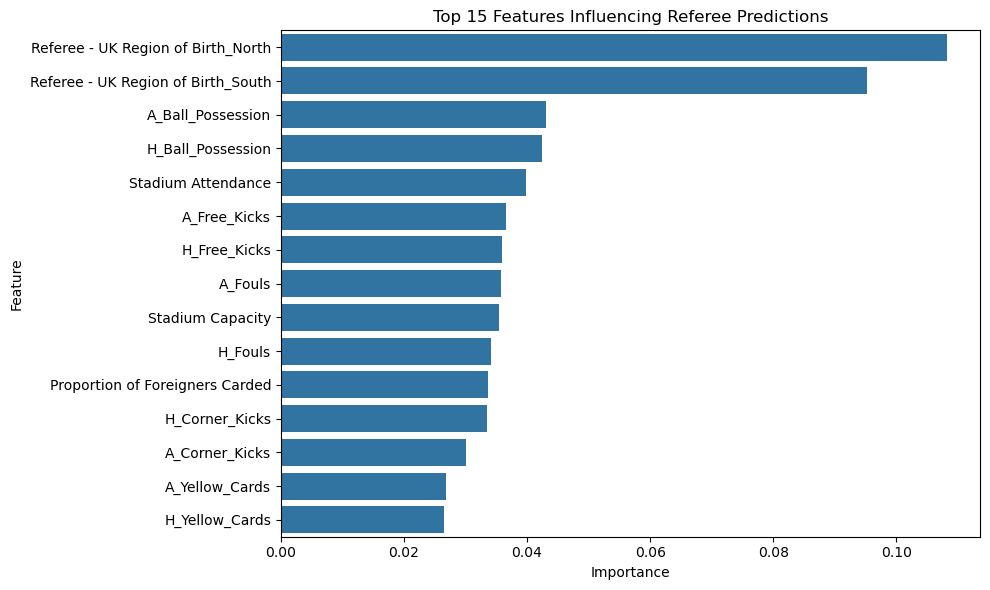

In [265]:
# ----------------------- #
# Step 10 - Visualize it! #
# ----------------------- #
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features Influencing Referee Predictions')
plt.tight_layout()
plt.show()

In [118]:
# # ------------------- #
# # Step 8: ParamGrid ! #
# # ------------------- #
# rf = RandomForestClassifier(random_state=42)
# param_grid = {
#     'n_estimators': [100,200,300],
#     'max_depth': [None, 10,20,30],
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [1,2,4],
#     'class_weight': [None, 'balanced']
# }

# grid_search = GridSearchCV(
#     estimator = rf,
#     param_grid = param_grid,
#     cv = 3,
#     n_jobs = -1,
#     verbose = 2
# )

# grid_search.fit(x_train, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Accuracy: ", grid_search.best_score_)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(x_test)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

# rf.fit(x_train, y_train)

In [ ]:
# -------------------------- #
# Step 12 - Multiple Models! #
# -------------------------- #
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000), # Add regularization to the parameters
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(max_depth= 20, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=20) # Adjust, make this smaller depending
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, zero_division=0))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)

In [ ]:
# -------------------------- #
# Visualize multiple models! #
# -------------------------- #

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Accuracy", y="Model")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

In [266]:
# ---------------------------------------------- #
# Last Step - Save joblib for Streamlit Purposes #
# ---------------------------------------------- #
# import joblib

# model = joblib.load("Referee_Model/referee_model.pkl")
# model.named_steps


# preprocessor = model.named_steps['preprocess']
# feature_names = preprocessor.get_feature_names_out()
# feature_names

print(Target, list(x_encoded.columns))

Referee ['Stadium Capacity', 'Stadium Attendance', 'Proportion of Foreigners Carded', 'H_Score', 'A_Score', 'H_Ball_Possession', 'A_Ball_Possession', 'H_Free_Kicks', 'A_Free_Kicks', 'H_Corner_Kicks', 'A_Corner_Kicks', 'H_Fouls', 'A_Fouls', 'H_Yellow_Cards', 'A_Yellow_Cards', 'H_Red_Cards', 'A_Red_Cards', 'PenaltiesAwarded', 'Home_Aston Villa', 'Home_Birmingham', 'Home_Blackburn', 'Home_Blackpool', 'Home_Bolton', 'Home_Bournemouth', 'Home_Brentford', 'Home_Brighton', 'Home_Burnley', 'Home_Cardiff', 'Home_Chelsea', 'Home_Crystal Palace', 'Home_Everton', 'Home_Fulham', 'Home_Huddersfield', 'Home_Hull', 'Home_Ipswich', 'Home_Leeds', 'Home_Leicester', 'Home_Liverpool', 'Home_Luton', 'Home_Manchester City', 'Home_Manchester Utd', 'Home_Middlesbrough', 'Home_Newcastle', 'Home_Norwich', 'Home_Nottingham', 'Home_Portsmouth', 'Home_QPR', 'Home_Reading', 'Home_Sheffield Utd', 'Home_Southampton', 'Home_Stoke', 'Home_Sunderland', 'Home_Swansea', 'Home_Tottenham', 'Home_Watford', 'Home_West Brom', '